# Whole brain data processing

### Making mask

In [3]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft
import fish_proc.utils.dask_ as fdask

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [2]:
## STEP 1: specify data and save path
dir_root = '/nrs/ahrens/jing/giving_up/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/im'
save_root = '/nrs/ahrens/jing/giving_up/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/weiz_processed/'
dask_tmp = '/nrs/ahrens/jing/giving_up/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/weiz_processed/dask-worker-space'
memory_limit = 0 # unlimited
if not os.path.exists(save_root):
    os.makedirs(save_root)

## Mask
Making a mask for data to decrease the number of computation in demix
* remove low intensity pixel
* remove low snr pixel
* remove low local pixel correlation pixels

This will generate the follow files at `save_root` folder
* `mask_map.h5` -- mask
* `local_correlation_map.h5` -- local correlation
* `masked_local_pca_data.zarr` -- df/f computation
* `masked_downsampled_local_pca_data.zarr` -- downsampled in time -> used for cell segmentation, which can be removed afterwards

### Note
* ZW -- intensity_percentile can be experimented using notebook `Test_for_pipeline_mask`
* ZW -- I used 50% for examplary data

### Create Mask

In [4]:
cluster, client = fdask.setup_workers(is_local=True, dask_tmp=dask_tmp, memory_limit=memory_limit)
print_client_links(cluster)

Scheduler: inproc://10.150.100.212/166083/1
Dashboard link: http://10.150.100.212/166083/1:8787/status


In [5]:
Y = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
Y_b = Y - Y_d
Y_b_max_mask = Y_b.max(axis=-1, keepdims=True)>2
Y_b_min_mask = Y_b.min(axis=-1, keepdims=True)>1
mask = Y_b_max_mask & Y_b_min_mask
mask.to_zarr(f'{save_root}/mask_map.zarr', overwrite=True)
# dff does not work --
# Ydd = Y_d/Y_b
# Ydd_max = Ydd.max(axis=-1, keepdims=True)
# Ydd_max.to_zarr(f'{save_root}/Y_max.zarr', overwrite=True)

In [6]:
# remove meaning before svd (-- pca)
# refresh_workers(cluster, numCores=60)
# Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
# Y_d_ave = Y_d.mean(axis=-1, keepdims=True, dtype='float32')
# print('Save average data ---')
# Y_d_ave.to_zarr(f'{save_root}/Y_ave.zarr')

Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
Y_d_max = Y_d.max(axis=-1, keepdims=True)
print('Save average data ---')
Y_d_max.to_zarr(f'{save_root}/Y_max.zarr', overwrite=True)  

Save average data ---


tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7f9d3c4076a0>>
Traceback (most recent call last):
  File "/groups/ahrens/home/weiz/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/ioloop.py", line 907, in _run
    return self.callback()
  File "/groups/ahrens/home/weiz/anaconda3/envs/myenv/lib/python3.7/site-packages/bokeh/server/tornado.py", line 558, in _keep_alive
    c.send_ping()
  File "/groups/ahrens/home/weiz/anaconda3/envs/myenv/lib/python3.7/site-packages/bokeh/server/connection.py", line 80, in send_ping
    self._socket.ping(codecs.encode(str(self._ping_count), "utf-8"))
  File "/groups/ahrens/home/weiz/anaconda3/envs/myenv/lib/python3.7/site-packages/tornado/websocket.py", line 447, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


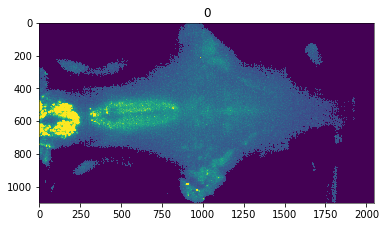

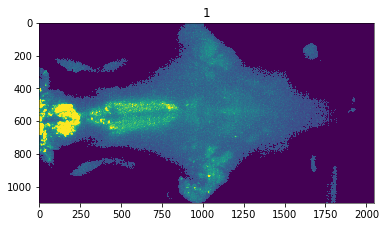

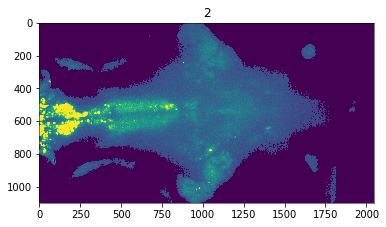

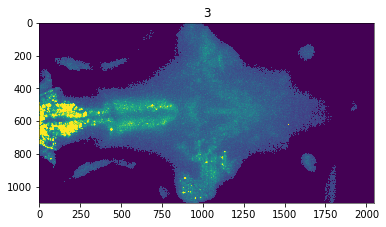

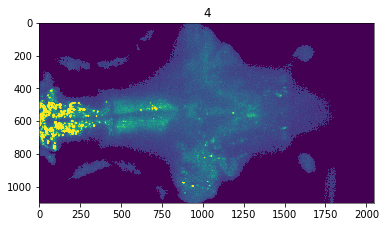

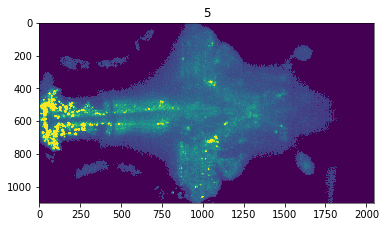

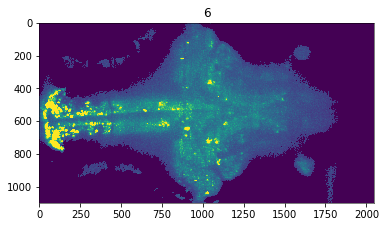

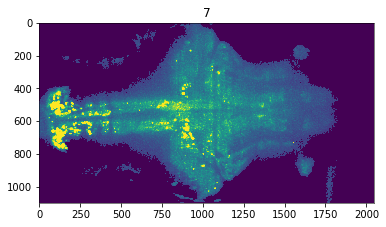

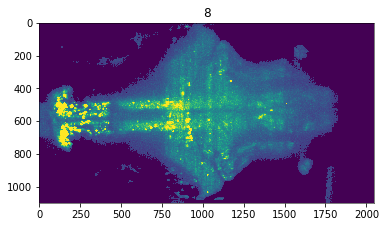

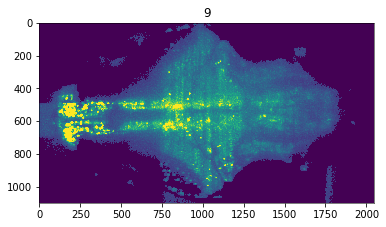

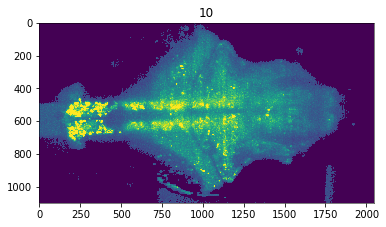

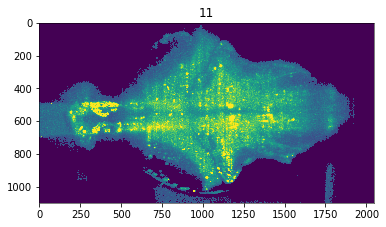

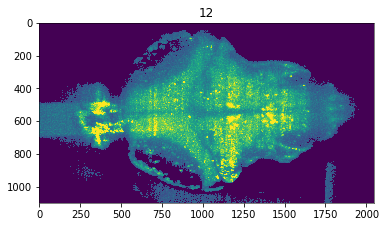

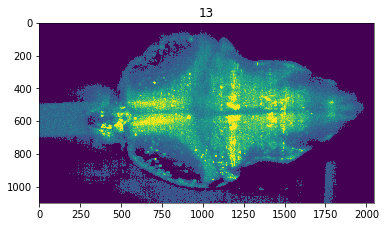

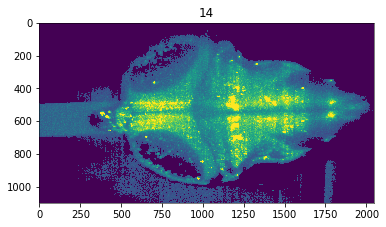

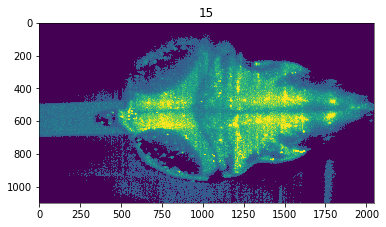

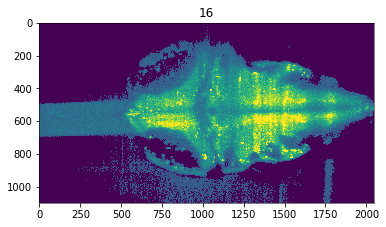

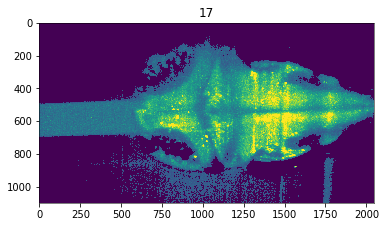

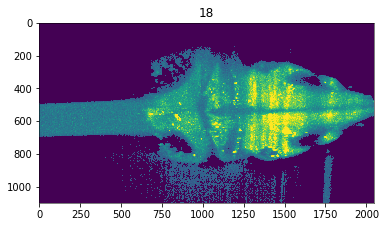

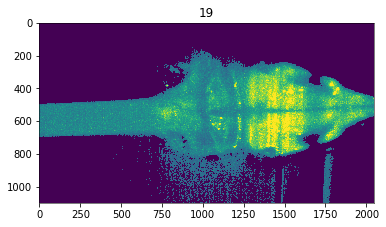

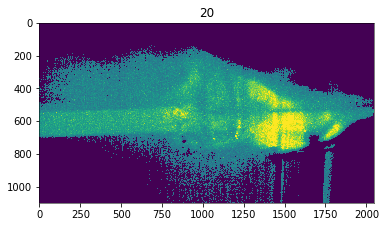

In [7]:
Y_d = zarr.open(f'{save_root}/Y_max.zarr', 'r')
mask = zarr.open(f'{save_root}/mask_map.zarr', 'r')
for n, n_ave_ in enumerate(Y_d):
    _ = n_ave_.squeeze().copy()
    _[~mask[n].squeeze()] = 0
    plt.imshow(_, vmax=np.percentile(_, 99))
    plt.title(n)
    plt.show()

### Other choice of map

In [ ]:
mask = mask.compute()

In [ ]:
da.from_array(mask, chunks=(1, x//nsplit, y//nsplit, -1)).to_zarr(f'{save_root}/mask_map.zarr', overwrite=True)

In [ ]:
# Y_d_ave_ = zarr.open(f'{save_root}/Y_ave.zarr', 'r')
Y_d_ave_ = zarr.open(f'{save_root}/Y_max.zarr', 'r')
intensity_percentile = np.ones(Y_d_ave_.shape[0])*50
intensity_percentile[17] = 70
intensity_percentile[18] = 80
intensity_percentile[19] = 90
intensity_percentile[20] = 95
mask = np.zeros(Y_d_ave_.shape).astype('bool')
for n, n_ave_ in enumerate(Y_d_ave_):
    mask_ = intesity_mask(n_ave_, intensity_percentile[n])
    mask_median = sfilter.median_filter(mask_.squeeze().astype('int'), size=7) == 1
    mask[n] = mask_ & mask_median[:, :, None]
z, x, y, _ = mask.shape
cluster, client = fdask.setup_workers(1)
mask = da.from_array(mask, chunks=(1, x//nsplit, y//nsplit, -1))
mask_sum = mask.map_blocks(lambda v:v.sum()*np.ones((1, x//nsplit, y//nsplit, 1))).compute()>2500
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    plt.imshow(mask_sum[n].squeeze(), cmap='gray', alpha=0.3)
    plt.title(n)
    plt.show()

### Overwrite the previous mask if the current one is going to be used

In [ ]:
da.from_array((mask.compute() & mask_sum), chunks=(1, x//nsplit, y//nsplit, -1)).to_zarr(f'{save_root}/mask_map.zarr', overwrite=True)

### Check again the mask before other processing

In [ ]:
mask = da.from_zarr(f'{save_root}/mask_map.zarr')

In [ ]:
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    plt.title(n)
    plt.show()

In [8]:
fdask.terminate_workers(cluster, client)